# **Step 1 — Import Libraries & Load Dataset**

In [1]:
# Basic setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib


# **Step 2 — Basic Data Cleaning** **bold text**

In [2]:
# Load CSV file
df = pd.read_csv("student_habits_performance.csv", encoding='utf-8')

# Show first few rows
df.head()

# Check for missing values
print("Missing values before handling:\n", df.isnull().sum())

# Fill missing values in parental_education_level with most common value (mode)
df['parental_education_level'].fillna(df['parental_education_level'].mode()[0], inplace=True)

print("\nMissing values after handling:\n", df.isnull().sum())


Missing values before handling:
 student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

Missing values after handling:
 student_id                       0
age                              0
gender                           0
study_hours_per_day              0
social_media_hours               0
netflix_hours                    0
part_time_job                    0
attendance_percentage            0
sleep_hours                      0
diet_quality                  

/tmp/ipython-input-2866735997.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['parental_education_level'].fillna(df['parental_education_level'].mode()[0], inplace=True)


# **Step 3 — Feature Engineering**

*   total_distractions = social_media_hours + netflix_hours
*   focus_index = study_hours_per_day ÷ (total_distractions + 1)
*   Convert diet quality to numeric scores
*   Create a health_score





In [3]:
# Encode diet quality to numeric points
df['diet_points'] = df['diet_quality'].map({'Good': 3, 'Fair': 2, 'Poor': 1})

# Total distractions = social media + Netflix
df['total_distractions'] = df['social_media_hours'] + df['netflix_hours']

# Focus index = study hours / (total distractions + small constant)
df['focus_index'] = df['study_hours_per_day'] / (df['total_distractions'] + 1e-6)

# Health score = sleep + exercise + diet
df['health_score'] = df['sleep_hours'] + df['exercise_frequency'] + df['diet_points']

# Show new columns
df[['study_hours_per_day', 'social_media_hours', 'netflix_hours', 'total_distractions', 'focus_index', 'health_score']].head()


,study_hours_per_day,social_media_hours,netflix_hours,total_distractions,focus_index,health_score
0,0.0,1.2,1.1,2.3,0.000000,16.0
1,6.9,2.8,2.3,5.1,1.352941,13.6
2,1.4,3.1,1.3,4.4,0.318182,10.0
3,1.0,3.9,1.0,4.9,0.204082,14.2
4,5.0,4.4,0.5,4.9,1.020408,9.9


# **Step 4 — Create Target Column**



*   HIGH RISK → exam_score < 50
*   MEDIUM RISK → 50–69
*   LOW RISK → ≥ 70


In [4]:
# Define function for labeling procrastination risk
def label_risk(score):
    if score < 50:
        return 'HIGH'
    elif score < 70:
        return 'MEDIUM'
    else:
        return 'LOW'

# Apply function
df['procrastination_risk'] = df['exam_score'].apply(label_risk)

# Encode risk as numeric for ML
df['risk_encoded'] = df['procrastination_risk'].map({'HIGH': 2, 'MEDIUM': 1, 'LOW': 0})

# Verify results
df[['exam_score', 'procrastination_risk', 'risk_encoded']].head()


,exam_score,procrastination_risk,risk_encoded
0,56.2,MEDIUM,1
1,100.0,LOW,0
2,34.3,HIGH,2
3,26.8,HIGH,2
4,66.4,MEDIUM,1


# **Step 5 — Encode Text Columns into Numbers**

In [5]:
# Define encoding maps
encode_map = {
    'gender': {'Male': 0, 'Female': 1, 'Other': 2},
    'part_time_job': {'Yes': 1, 'No': 0},
    'extracurricular_participation': {'Yes': 1, 'No': 0},
    'diet_quality': {'Poor': 1, 'Fair': 2, 'Good': 3},
    'internet_quality': {'Poor': 1, 'Average': 2, 'Good': 3},
    'parental_education_level': {'None': 0, 'High School': 1, 'Bachelor': 2, 'Master': 3}
}

# Apply encodings
df.replace(encode_map, inplace=True)

# Check one sample
df.head(3)


/tmp/ipython-input-2066218178.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(encode_map, inplace=True)


,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,...,internet_quality,mental_health_rating,extracurricular_participation,exam_score,diet_points,total_distractions,focus_index,health_score,procrastination_risk,risk_encoded
0,S1000,23,1,0.0,1.2,1.1,0,85.0,8.0,2,...,2,8,1,56.2,2,2.3,0.000000,16.0,MEDIUM,1
1,S1001,20,1,6.9,2.8,2.3,0,97.3,4.6,3,...,2,8,0,100.0,3,5.1,1.352941,13.6,LOW,0
2,S1002,21,0,1.4,3.1,1.3,0,94.8,8.0,1,...,1,1,0,34.3,1,4.4,0.318182,10.0,HIGH,2


# **Step 6 — Choose Final Features for Training**

In [6]:
# Select key features for the ML model
selected_features = [
    'study_hours_per_day',
    'social_media_hours',
    'netflix_hours',
    'total_distractions',
    'focus_index',
    'sleep_hours',
    'mental_health_rating',
    'attendance_percentage',
    'diet_quality',
    'exercise_frequency',
    'part_time_job',
    'age'
]

X = df[selected_features]
y = df['risk_encoded']

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)


Feature matrix shape: (1000, 12)
Target shape: (1000,)


# **Step 7 — Train-Test Split + Random Forest Training**

In [7]:
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 700
Testing samples: 300


# **Step 8 — Evaluate Model**

✅ Model training complete!
🎯 Model Accuracy: 0.80

📊 Classification Report:
               precision    recall  f1-score   support

         LOW       0.85      0.86      0.86       153
      MEDIUM       0.70      0.76      0.73       106
        HIGH       0.93      0.66      0.77        41

    accuracy                           0.80       300
   macro avg       0.83      0.76      0.79       300
weighted avg       0.81      0.80      0.80       300



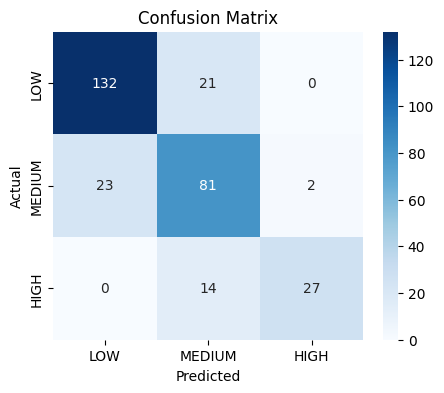

In [8]:
# Train Random Forest model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

model.fit(X_train, y_train)
print("✅ Model training complete!")

# Predictions
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"🎯 Model Accuracy: {acc:.2f}")

# Classification report
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=['LOW', 'MEDIUM', 'HIGH']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['LOW', 'MEDIUM', 'HIGH'], yticklabels=['LOW', 'MEDIUM', 'HIGH'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



# **Step 9 — Save Model & Results**

In [9]:
# Save the trained model
joblib.dump(model, "trained_model.pkl")
print("💾 Model saved as trained_model.pkl")

# Optionally save results
with open("model_training_results.txt", "w") as f:
    f.write(f"Accuracy: {acc:.2f}\n")


💾 Model saved as trained_model.pkl


# **Step 10 — Try Sample Predictions**

In [10]:
# Example new student data for testing
sample = pd.DataFrame([{
    'study_hours_per_day': 2,
    'social_media_hours': 4,
    'netflix_hours': 3,
    'total_distractions': 7,
    'focus_index': 2 / (7 + 1),
    'sleep_hours': 5,
    'mental_health_rating': 4,
    'attendance_percentage': 70,
    'diet_quality': 2,
    'exercise_frequency': 2,
    'part_time_job': 0,
    'age': 21
}])

prediction = model.predict(sample)[0]
risk_label = {0:'LOW', 1:'MEDIUM', 2:'HIGH'}[prediction]

print(f"📘 Predicted Procrastination Risk: {risk_label}")


📘 Predicted Procrastination Risk: HIGH
